# A7: Multi-Class Model Selection using ROC and Precision-Recall Curves 

## Part A: Data Preparation and Baseline

We will do API call to the UCI Machine Learning Repository to download the Statlog Landsat Satellite dataset.

In [116]:
from ucimlrepo import fetch_ucirepo 
  
statlog_landsat_satellite = fetch_ucirepo(id=146) 
  
X = statlog_landsat_satellite.data.features 
y = statlog_landsat_satellite.data.targets 


We will remove class 6 which is the class where all types are present.

In [117]:
from sklearn.preprocessing import LabelEncoder

# removing class 6 which is mixed class
mix_index = y[y['class'] == 6].index
y = y.drop(index=mix_index)
X = X.drop(index=mix_index)

y = y.reset_index(drop=True)
X = X.reset_index(drop=True)

le = LabelEncoder()
y = le.fit_transform(y['class'])

We will standardize the feature X.

In [118]:
from sklearn.preprocessing import StandardScaler
# Standarizing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

We will now split the data into training and testing sets. 

In [119]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.25,random_state=42)

We will now train the 6 models

In [120]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import time

# Dictionary to store all model instances
models = {}

# K-Nearest Neighbors
models['KNN'] = KNeighborsClassifier().fit(X_train, y_train)

# Decision Tree Classifier
models['Decision Tree'] = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

# Dummy Classifier (Baseline)

models['Dummy (Prior)'] = DummyClassifier(strategy='prior', random_state=42).fit(X_train, y_train)

# Logistic Regression
models['Logistic Regression'] = LogisticRegression(
    max_iter=1000, 
    random_state=42
).fit(X_train, y_train)

# Gaussian Naive Bayes
models['Gaussian Naive Bayes'] = GaussianNB().fit(X_train, y_train)

# Support Vector Machine (SVC)
models['SVC'] = SVC(
    probability=True, 
    random_state=42
).fit(X_train, y_train)


We will now calculate the simple Overall Accuracy and Weighted F1-Score for all six models on the test set.

In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
overall_accuracy={}
weighted_f1={}
yhat={}
for key in models:
    yhat = models[key].predict(X_test)
    overall_accuracy[key]= accuracy_score(y_test, yhat)
    weighted_f1[key]= f1_score(y_test, yhat, average='weighted')


summary_data = pd.DataFrame([overall_accuracy, weighted_f1], index=['overall_accuracy', 'weighted_f1'])
summary_data=summary_data.T
# Apply your preferred styling
summary_output = (
    summary_data
    .style
    .set_properties(**{'text-align': 'center'})  # center all text
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},  # center headers
        {'selector': '.row_heading', 'props': [('font-weight', 'bold'), ('text-align', 'center')]}  # bold + center index
    ])
)

# Display styled table
summary_output

,overall_accuracy,weighted_f1
KNN,0.903667,0.904205
Decision Tree,0.844624,0.846379
Dummy (Prior),0.228092,0.084726
Logistic Regression,0.858919,0.853822
Gaussian Naive Bayes,0.793039,0.803454
SVC,0.891237,0.890580


We can see that Dummy Classifier (Prior) performs the worst. The overall accuracy and weighted f1 is less compared to other models by several factors. 

## Part B: ROC Analysis for Model Selection

Receiver Operating Characteristic (ROC) analysis is fundamentally defined for binary classification problems. To extend this to multi class classification One-vs-Rest (OvR) is used.

In One-vs-Rest (OvR) approach:
- We treate each class as the positive class while the remaining class is combined into a single negative class.
Each class is treated as the positive class once, while all remaining classes are combined into a single negative class.

- For each class the classifier gives a predicted probability or a decision score. Based on this we compute True Positive Rate (TPR) and False Positive Rate (FPR)at different threshold values.
 
- One ROC curve is generated per class for each model, then macro averaged (the non weighted average) curve is then plotted. We aslo calculate Area Under the Curve (AUC) by finding the AUC of each curve and then taking the macro average of it.

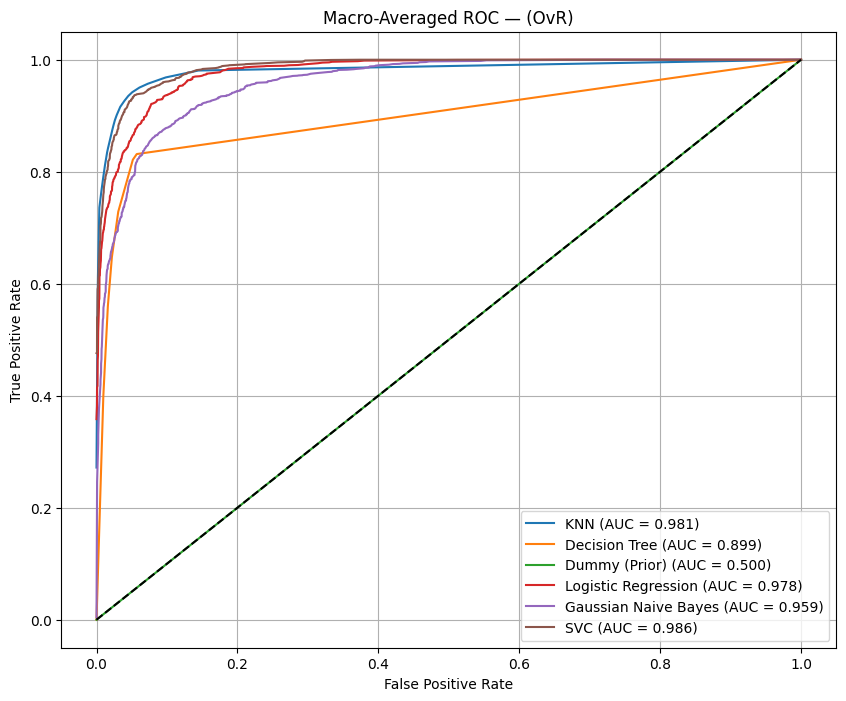

Macro-Averaged AUC Scores:
KNN: 0.981
Decision Tree: 0.899
Dummy (Prior): 0.500
Logistic Regression: 0.978
Gaussian Naive Bayes: 0.959
SVC: 0.986


In [122]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Binarize the labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = len(classes)

plt.figure(figsize=(10, 8))
roc_auc_scores = {}

for name, model in models.items():
    
    try:
        y_score = model.predict_proba(X_test)
    except:
        y_score = model.decision_function(X_test)

    # Store per-class data
    fpr = {}
    tpr = {}
    roc_auc = []
    
    # Compute class-wise ROC
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc.append(auc(fpr[i], tpr[i]))

    # Macro-average curve: interpolate onto common FPR grid
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    roc_auc_scores[name] = macro_auc

    # Plot final averaged curve
    plt.plot(all_fpr, mean_tpr, label=f'{name} (AUC = {macro_auc:.3f})')

# Random chance line
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Averaged ROC — (OvR)")
plt.grid(True)
plt.legend()
plt.show()

print("Macro-Averaged AUC Scores:")
for name, score in roc_auc_scores.items():
    print(f"{name}: {score:.3f}")



**Support Vector Classification** model is the model with the **highest Macro-averaged AUC**. KNN model and Logistic Regression model closely follows it.

The Dummy Classifier with strategy as 'prior' does not any anything form the input features. The class probability is equal to the frequency distribution of each class. So a class a particular input is assigned is independet to the input feature. True Positive Rate and False Positive Rate changes in the same proportion (like the graph above), so the AUC of it will be $\approx 0.5$

## Part C: Precision-Recall Curve (PRC) Analysis

ROC measures classification performance using True Positive Rate (TPR) and False Positive Rate (FPR) changes. In this case even if we have a poor classifier for a heavily imbalanced datset the FPR will be still be low as most samples will be predicted as negative which gives a high Area Under the Curve (AUC). Thus ROC is optimistic in this case.

Precision–Recall Curve (PRC) focuses on precison and recall which only focusses on the postive class. So in the case of heavily imbalanced dataset it captures how many positive predictions are correct and what fraction on the postive it actually detects. So from the PRC curve we can see whether it will capture the minority positive class effectively. So PRC is a more suitable metric than ROC.

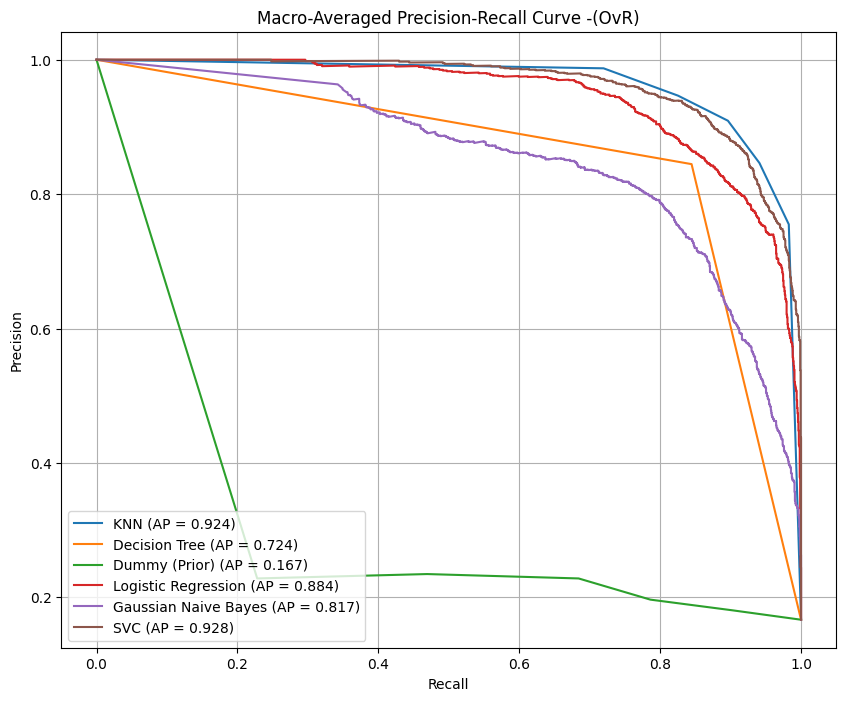

Macro-Averaged Average Precision (AP) Scores:
KNN: 0.9242
Decision Tree: 0.7243
Dummy (Prior): 0.1667
Logistic Regression: 0.8838
Gaussian Naive Bayes: 0.8167
SVC: 0.9277


In [123]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

model_ap = {}

plt.figure(figsize=(10, 8))

for name, model in models.items():

    # Get probabilities or decision scores
    try:
        y_proba = model.predict_proba(X_test)
    except:
        y_proba = model.decision_function(X_test)

    ap_scores = []
    for i in range(len(classes)):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
        ap = average_precision_score(y_test_bin[:, i], y_proba[:, i])
        ap_scores.append(ap)

    macro_ap = np.mean(ap_scores)
    model_ap[name] = macro_ap

    # Macro curve for visualization
    precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_proba.ravel())
    plt.plot(recall, precision, label=f'{name} (AP = {macro_ap:.3f})')

plt.title("Macro-Averaged Precision-Recall Curve -(OvR)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='lower left')
plt.grid()
plt.show()

print("Macro-Averaged Average Precision (AP) Scores:")
for name, score in model_ap.items():
    print(f"{name}: {score:.4f}")


**Support Vector Classification** model is the model with the **highest Macro-averaged AUC**. KNN model and Logistic Regression model closely follows it.

Recall measure how many of the actual positive sample the classifier detects $\big(\text{Recall}=\frac{\text{TP}}{\text{TP+FN}}\big)$. 

But for a poor classifier when recall increase it means it captures a lot of false positives along with true positives. In this case precision decreases $\big(\text{Precision}=\frac{\text{TP}}{\text{TP+FP}}\big)$. Therefore the **PRC curve drop sharply as recall increases for poor models**.

## Part D: Final Recommendation

### Results

In [124]:
summary_data = pd.DataFrame([weighted_f1,roc_auc_scores,model_ap], index=['weighted_f1','AUC scores', 'AP scores'])
summary_data=summary_data.T
# Apply your preferred styling
summary_output = (
    summary_data
    .style
    .set_properties(**{'text-align': 'center'})  # center all text
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},  # center headers
        {'selector': '.row_heading', 'props': [('font-weight', 'bold'), ('text-align', 'center')]}  # bold + center index
    ])
)
summary_data

,weighted_f1,AUC scores,AP scores
KNN,0.904205,0.981021,0.924171
Decision Tree,0.846379,0.898785,0.724274
Dummy (Prior),0.084726,0.500000,0.166667
Logistic Regression,0.853822,0.978222,0.883757
Gaussian Naive Bayes,0.803454,0.959321,0.816713
SVC,0.890580,0.986106,0.927749


Model when ranked from highest to lowest wrt to weighted F1, AUC scores, AP scores are:\\
- weighted F1
$$\text{KNN, SVC, Decision Tree, Logistic Regression,Gaussian Naive Bayes, Dummy (Prior)}$$
- AUC scores
$$\text{SVC, KNN, Logistic Regression, Gaussian Naive Bayes, Decision Tree,  Dummy (Prior)}$$
- AP scores
$$\text{SVC, KNN, Logistic Regression, Gaussian Naive Bayes, Decision Tree,  Dummy (Prior)}$$

Model ranking for the performance based on AUC scores and AP scores is the same, but it is slightly different when compared with weighted F1 scores. 

SVC performs better than KNN and Decision Tree performs worse than Logistic Regression and Gaussian Naive Bayes in AUC and AP when compered with weighted F1.

Weighted F1 score evaluates the model only at a single decision threshold while AUC and AP measures the performance across all possible thresholds. Therefore AUC and AP gives a better indicator of the goodness of the model

### Recommendation

Based on the above analysis I would recommend using **Support Vector Classification** as it has a better AUC and AP score. We priorities AUC and AP score over weighted F1 score as the former captures performance at all threshholds.

## Extra Models (Random Forest and XGBoost)

We will use RandomForest and XGBoost classifiers. We will compute the weighted f1 scores and compare it with the previous models.

In [125]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models["Random Forest"] = RandomForestClassifier(n_estimators=200, random_state=42)
models["XGBoost"] = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
models["Random Forest"].fit(X_train, y_train)
models["XGBoost"].fit(X_train, y_train)

weighted_f1["XGBoost"]= f1_score(y_test, yhat, average='weighted')
weighted_f1["Random Forest"]= f1_score(y_test, yhat, average='weighted')

summary_data = pd.DataFrame([weighted_f1], index=['weighted_f1'])
summary_data=summary_data.T

summary_output = (
    summary_data
    .style
    .set_properties(**{'text-align': 'center'}) 
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},  
        {'selector': '.row_heading', 'props': [('font-weight', 'bold'), ('text-align', 'center')]}  
    ])
)

summary_output

C:\Users\asher\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [17:22:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,weighted_f1
KNN,0.904205
Decision Tree,0.846379
Dummy (Prior),0.084726
Logistic Regression,0.853822
Gaussian Naive Bayes,0.803454
SVC,0.890580
XGBoost,0.890580
Random Forest,0.890580


We can see that XGBoost and Random Forest have similar weighted average as that SVC but lesser than of KNN.

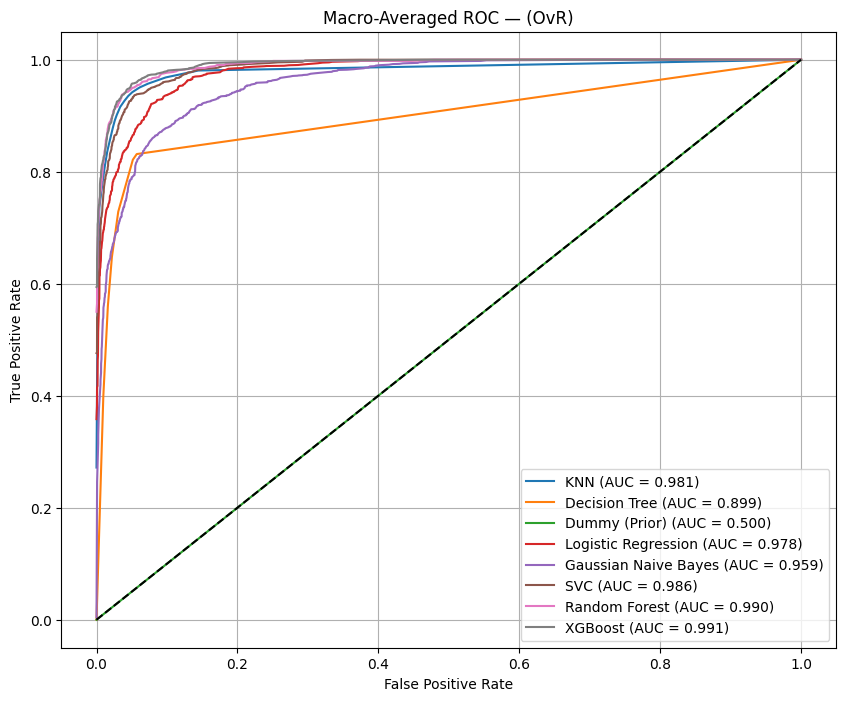

Macro-Averaged AUC Scores:
KNN: 0.981
Decision Tree: 0.899
Dummy (Prior): 0.500
Logistic Regression: 0.978
Gaussian Naive Bayes: 0.959
SVC: 0.986
Random Forest: 0.990
XGBoost: 0.991


In [126]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Binarize the labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = len(classes)

plt.figure(figsize=(10, 8))
roc_auc_scores = {}

for name, model in models.items():
    
    try:
        y_score = model.predict_proba(X_test)
    except:
        y_score = model.decision_function(X_test)

    # Store per-class data
    fpr = {}
    tpr = {}
    roc_auc = []
    
    # Compute class-wise ROC
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc.append(auc(fpr[i], tpr[i]))

    # Macro-average curve: interpolate onto common FPR grid
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    roc_auc_scores[name] = macro_auc

    # Plot final averaged curve
    plt.plot(all_fpr, mean_tpr, label=f'{name} (AUC = {macro_auc:.3f})')

# Random chance line
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Averaged ROC — (OvR)")
plt.grid(True)
plt.legend()
plt.show()

print("Macro-Averaged AUC Scores:")
for name, score in roc_auc_scores.items():
    print(f"{name}: {score:.3f}")



**We can see that XGBoost and Random Forest have way better performance than other models**

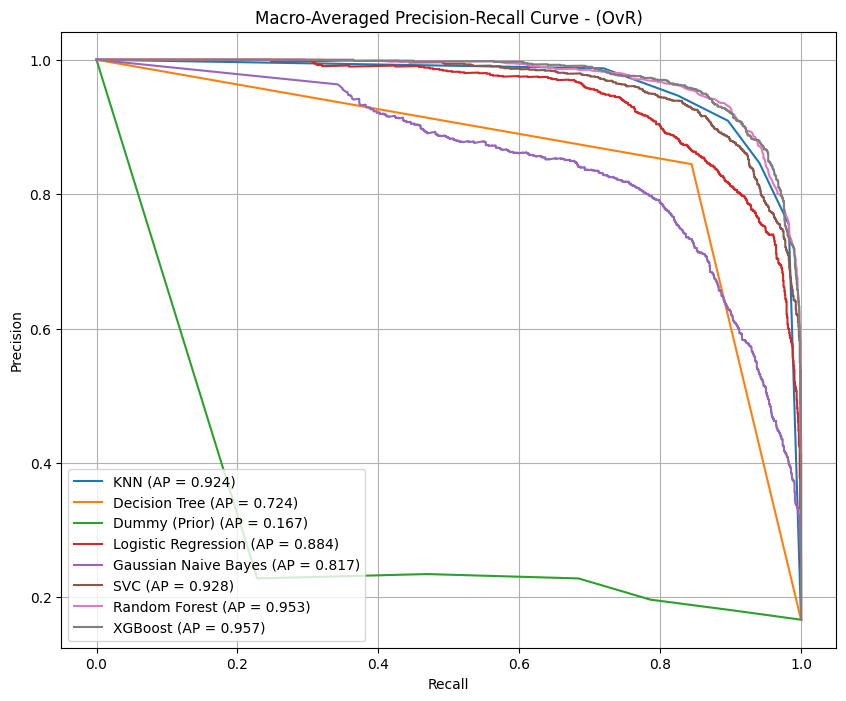

Macro-Averaged Average Precision (AP) Scores:
KNN: 0.9242
Decision Tree: 0.7243
Dummy (Prior): 0.1667
Logistic Regression: 0.8838
Gaussian Naive Bayes: 0.8167
SVC: 0.9277
Random Forest: 0.9525
XGBoost: 0.9566


In [127]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

model_ap = {}

plt.figure(figsize=(10, 8))

for name, model in models.items():

    # Get probabilities or decision scores
    try:
        y_proba = model.predict_proba(X_test)
    except:
        y_proba = model.decision_function(X_test)

    ap_scores = []
    for i in range(len(classes)):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
        ap = average_precision_score(y_test_bin[:, i], y_proba[:, i])
        ap_scores.append(ap)

    macro_ap = np.mean(ap_scores)
    model_ap[name] = macro_ap

    # Macro curve for visualization
    precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_proba.ravel())
    plt.plot(recall, precision, label=f'{name} (AP = {macro_ap:.3f})')

plt.title("Macro-Averaged Precision-Recall Curve - (OvR)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='lower left')
plt.grid()
plt.show()

print("Macro-Averaged Average Precision (AP) Scores:")
for name, score in model_ap.items():
    print(f"{name}: {score:.4f}")


**Again we can see that XGBoost and Random Forest have way better performance than other models**. XGBoost performs slightly better than Random Forest.

We priorities AUC and AP score over weighted F1 score as the former captures performance at all threshholds. So based on the above analysis I would recommend using **XGBoost** as it has a better AUC (but wrt to random forest it is a similar score) and AP score. 